In [1]:
LOCATION_HISTORY_FILE='/home/pere/Semantic_Location_History/2020/2020_MAY.json'
TIME_ZONE='Europe/Berlin'

In [133]:
import json
import datetime

import shapely.geometry as sg
import pandas as pd
import geopandas as gp
from matplotlib import cm
import numpy as np
import scipy as sp

In [3]:
history = json.load(open(LOCATION_HISTORY_FILE))

In [4]:
len(history['timelineObjects'])

54

## 1 - Convert semantic history into a DataFrame and do some exploratory data analysis on it

In [5]:
def get_point(obj):
    """
    Returns a shapely.geometry.Point from an object that has the
    attributes "longitudeE7" and "latitudeE7"
    """
    return sg.Point(obj["longitudeE7"] / 10000000,
                    obj["latitudeE7"] / 10000000)

In [6]:
def to_datetime_tz(ms):
    return pd.to_datetime(ms, unit='ms').tz_localize('UTC').tz_convert(TIME_ZONE)

In [7]:
def get_raw_path_point(obj):
    """
    Returns a tuple with a shapely.geometry.Point and a datetime, 
    corresponding to a point in a sampled time-path e.g. what you can
    find in 'simplifiedRawPath' in 'activitySegment' objects
    """
    return (
        sg.Point(obj["lngE7"] / 10000000,
                 obj["latE7"] / 10000000),
        to_datetime_tz(obj['timestampMs'])
    )

In [8]:
def calc_duration_minutes(duration_obj):
    """ return the minutes from the difference in the object below:
    
      "duration" : {
         "startTimestampMs" : "1585739488388",
         "endTimestampMs" : "1585759177100"
      }    
    """
    return int((int(duration_obj['endTimestampMs']) - 
                int(duration_obj['startTimestampMs'])) / 1000 / 60)

In [9]:
def elapsed_minutes(start_date, end_date):
    """Calculate integer elapsed minutes from two datetimes"""
    elapsed_time = end_date - start_date
    return int(
        divmod(elapsed_time.total_seconds(), 60)[0]
    )

In [10]:
def semantic_history_to_df(history):
    """
    Returns a pandas DataFrame from a semantic history JSON array.
    Unifies the most important information into a flat schema.
    
    Parameters
    ----------
    history: 
        ...
        
    Returns
    -------
    DataFrame
        ...
    """
    parsed_objs = []
    
    for obj in history['timelineObjects']:
        parsed_obj = {
        }
        if 'activitySegment' in obj:
            # activity properties
            parsed_obj.update({
                  'type': 'moving',
                  'activity_type': obj['activitySegment']['activityType'],
                  'place': 'MOVING',
                  'from_point': get_point(obj['activitySegment']['startLocation']),
                  'route': [get_raw_path_point(p) for p in 
                            obj['activitySegment']
                            .get('simplifiedRawPath', {})
                            .get('points', [])]
            })
            duration_obj = obj['activitySegment']['duration']
        elif 'placeVisit' in obj:
            # place visit properties
            parsed_obj.update({
                  'type': 'visit',
                  'place': (
                      'HOME' if obj['placeVisit']['location']
                                 .get('semanticType', '') == 'TYPE_HOME'
                             else obj['placeVisit']['location']['placeId']
                  ),
                  # if I'm visiting a place then I'd say I'm still?
                  'activity_type': 'STILL',
                  'from_point': get_point(obj['placeVisit']['location']),
                  'route': []
            })
            duration_obj = obj['placeVisit']['duration']
        else:
            # let me know if I missed something!
            raise Exception('Unknown timeline object: {}'.format(obj))

        # common properties
        parsed_obj.update({
            'start_date': to_datetime_tz(duration_obj['startTimestampMs']),
            'end_date': to_datetime_tz(duration_obj['endTimestampMs']),
            'duration_minutes': calc_duration_minutes(duration_obj),
            'latitude': parsed_obj['from_point'].y,
            'longitude': parsed_obj['from_point'].x,
        })
        
        parsed_objs.append(parsed_obj)
            
    df = pd.DataFrame(parsed_objs)
    
    return df

In [11]:
df = semantic_history_to_df(history)

In [20]:
df.head(1)

,activity_type,duration_minutes,end_date,from_point,latitude,longitude,place,route,start_date,type
0,WALKING,49,2020-05-01 19:40:05.967000+02:00,POINT (13.2707059 52.4300337),52.430034,13.270706,MOVING,"[(POINT (13.2704077 52.4217796), 2020-05-01 19...",2020-05-01 18:51:01.163000+02:00,moving


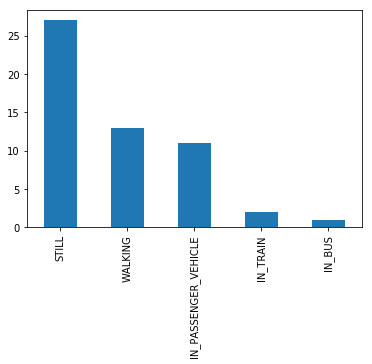

In [21]:
df['activity_type'].value_counts().plot(kind='bar')

## 2 - Convert exploratory DataFrame into a ML-ready representation for clustering

In [50]:
def interpolate_route(full_route, 
                      start_point, 
                      sample_interval_minutes):
    """
    Parameters
    ----------
    full_route: list
        A list of tuples (Point, int) describing geographic locations
        and minute offsets
    start_point: Point
        origin of the route at minute offset=0
    sample_interval_minutes: int
        Tells this function to interpolate a route at this fixed time interval
    
    Return
    ------
    list: 
        A list of tuples (Point, int) extended from the input route
        interpolated at a fixed time interval given by sample_interval_minutes
    
    """
    interpolated_route = []
    route_index = 0
    minute_index = sample_interval_minutes
    
    while route_index < len(full_route):
        if full_route[route_index][1] < minute_index:
            # look for the first sampled point in the path
            # which is ahead in time of the curren time point to sample
            route_index += 1
            continue
        
        # interpolate location
        prev_loc = start_point if route_index == 0 else full_route[route_index - 1][0]
        curr_loc = full_route[route_index][0]
        
        prev_mins_off = 0 if route_index == 0 else full_route[route_index - 1][1]
        curr_mins_off = full_route[route_index][1]
        
        diff_mins = curr_mins_off - prev_mins_off
        diff_mins_int = minute_index - prev_mins_off
        
        int_loc_x = prev_loc.x + ((curr_loc.x - prev_loc.x) / diff_mins) * diff_mins_int
        int_loc_y = prev_loc.y + ((curr_loc.y - prev_loc.y) / diff_mins) * diff_mins_int
        
        interpolated_route.append((sg.Point(int_loc_x,
                                            int_loc_y),
                                   minute_index))
        minute_index += sample_interval_minutes
                                  
    return interpolated_route

In [81]:
def extract_full_activities(df,
                            sample_interval_minutes):
    """
    Flatten the parsed semantic history in the DataFrame to a DataFrame of
    activites that start and end at home. Extract meaningful features such that 
    these activites can be compared to one another.
    
    Parameters
    ----------
    df: DataFrame given by `semantic_history_to_df`
        ...
    sample_interval_minutes: int
        Will interpolate full routes by sampling a geographic point every 'x' minutes

    Returns
    -------
    DataFrame
        Columns:
            start_date: datetime.date
            start_time: datetime.time
            end_date: datetime.date
            end_time: datetime.time
            start_weekday: int:
                ordinal ISO weekday (1-7)
            end_weekday: int: 
                ordinal ISO weekday (1-7)
            total_minutes: int
            full_route: list((Point, int)): 
                Interpolated route at a fixed time interval
            moving_by: list((str, int)):
                distinct ways of moving and minute offset relative to route
            visited_places: list((Point, int)):
                distinct places visited according to Google, and minute offset relative to route
    """
    all_acts = []
    act = {}
    
    for i, row in df.iterrows():
        if (row['place'] == 'HOME' and row['duration_minutes'] > 30 and act):
            # consider an activity finished if we arrived home and stay there for more than
            # half an hour
            act['end_date'] = row['start_date']
            act['end_time'] = datetime.datetime.time(row['start_date']).replace(second=0,
                                                                                microsecond=0)
            act['end_weekday'] = row['start_date'].isoweekday()
            act['total_minutes'] = elapsed_minutes(act['start_date'],
                                                   act['end_date'])
            
            # convert route datatimes into minute offsets (relative to total activity minutes)
            full_route_mo = []
            for rp in act['full_route']:
                elapsed = elapsed_minutes(act['start_date'], rp[1])
                # make a route as a list of tuples (Point, int) where 
                # the second element is the minute offset
                full_route_mo.append((rp[0], elapsed))
                
            # interpolate the route to a fixed time interval such that we can
            # compare two different routes
            act['full_route'] = interpolate_route(full_route_mo, 
                                                  start_point=row['from_point'],
                                                  sample_interval_minutes=sample_interval_minutes)
            act['end_date'] = datetime.datetime.date(row['end_date'])
            act['start_date'] = datetime.datetime.date(row['start_date'])

            if len(act['full_route']) == 0:
                print('Skipping activity with no route.')
                act = {}
                continue

            all_acts.append(act)
            act = {}
        else:
            if row['type'] == 'moving':
                if 'start_time' not in act:
                    act['start_date'] = row['start_date']
                    act['start_time'] = datetime.datetime.time(row['start_date']).replace(second=0,
                                                                                          microsecond=0)
                    act['start_weekday'] = row['start_date'].weekday()                
                act['full_route'] = (
                    act.get('full_route', []) + row['route']
                )
            elif row['type'] == 'visit':
                act['visited_places'] = (
                    act.get('visited_places', []) + 
                    [(row['from_point'], row['duration_minutes'])]
                )                
                act['full_route'] = (
                    act.get('full_route', []) + [(row['from_point'],
                                                  row['start_date'])]
                )
            act['moving_by'] = (
                act.get('moving_by', []) +
                [(row['activity_type'], row['duration_minutes'])]
            )
                
    return pd.DataFrame(all_acts)

In [82]:
MAX_ROUTE_DURATION = 6*60
INTERPOLATED_INTERVAL = 5

In [83]:
f_df = extract_full_activities(df, sample_interval_minutes=INTERPOLATED_INTERVAL)
f_df.head(1)

Skipping activity with no route.


,end_date,end_time,end_weekday,full_route,moving_by,start_date,start_time,start_weekday,total_minutes,visited_places
0,2020-05-02,20:22:00,5,"[(POINT (13.270097775 52.42694379166667), 5), ...","[(WALKING, 49), (STILL, 12), (WALKING, 29)]",2020-05-01,18:51:00,4,91,"[(POINT (13.2636161 52.4222327), 12)]"


In [119]:
# TODO This is too coupled with the constants above

def to_ml_vector_list(full_activities_df):
    """
    Converts a DataFrame returned by `extract_full_activities` into a list(list()) of numeric
    features that can be fed to any ML algorithm.    
    """
    ml_vector_list = []
    for i, row in full_activities_df.iterrows():
        if row['total_minutes'] > MAX_ROUTE_DURATION:
            print('Skipping route bigger than MAX_ROUTE_DURATION ({})'.format(row['total_minutes']))
            continue
        if row['end_weekday'] != row['start_weekday']:
            print('Skipping route that spawned overnight (ISO weekdays {} to {})'
                  .format(row['start_weekday'],
                          row['end_weekday']))
        features = {
            'total_minutes': row['total_minutes']
        }
        for weekday in range(1, 7):
            features['weekday_{}'.format(weekday)] = (
                1 if row['start_weekday'] == weekday else 0 
            )
            features['weekday_workweek'] = (
                1 if row['start_weekday'] < 6 else 0 
            )
            features['weekday_weekend'] = (
                1 if row['start_weekday'] >= 6 else 0 
            )
        for index, minutes in enumerate(range(INTERPOLATED_INTERVAL, 
                                              MAX_ROUTE_DURATION, 
                                              INTERPOLATED_INTERVAL)):
            time_position = (
                row['full_route'][index] if index < len(row['full_route'])
                else row['full_route'][-1]
            )
            if index < len(row['full_route']):
                # asserts that we're sampling the route in the same way
                # as the route was interpolated (see enumerate loop above)
                assert minutes == time_position[1]
            features['x_{}'.format(minutes)] = time_position[0].x
            features['y_{}'.format(minutes)] = time_position[0].y
        # convert the key -> value representation into a flat array
        # where the position has the same meaning in all cases
        ml_vector_list.append(np.array([i[1] for i in sorted(features.items())]))
    return np.array(ml_vector_list)

In [120]:
ml_vector_list = to_ml_vector_list(f_df)
n_features = len(ml_vector_list[0])

# assert that all vectors have the same number of features
for v in ml_vector_list:
    assert len(v) == n_features

Skipping route that spawned overnight (ISO weekdays 4 to 5)
Skipping route that spawned overnight (ISO weekdays 5 to 6)
Skipping route that spawned overnight (ISO weekdays 5 to 6)
Skipping route that spawned overnight (ISO weekdays 6 to 7)
Skipping route that spawned overnight (ISO weekdays 6 to 7)
Skipping route that spawned overnight (ISO weekdays 0 to 1)
Skipping route that spawned overnight (ISO weekdays 0 to 1)
Skipping route that spawned overnight (ISO weekdays 1 to 2)
Skipping route that spawned overnight (ISO weekdays 2 to 3)
Skipping route that spawned overnight (ISO weekdays 3 to 4)


## 3 - Try some clustering algorithms and visualize results

In [121]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

In [122]:
np.linalg.norm(ml_vector_list[0] - ml_vector_list[0])

0.0

In [132]:
# Calculate a distance distribution between the elements to get an idea of appropriate parameters
# for the clustering algorithm
distance_distribution = np.trim_zeros(
    np.unique(
        np.tril(
            pairwise_distances(ml_vector_list, metric='euclidean')
        )
    )
)

In [135]:
sp.stats.describe(distance_distribution)

DescribeResult(nobs=45, minmax=(3.691666301270348, 183.00201865291245), mean=69.89208709678672, variance=2083.1085916231627, skewness=0.6343778171347668, kurtosis=-0.37948471354996505)

In [144]:
# by now take the 20 percentile
# but something more sophisticated could be done: https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/#method-for-determining-the-optimal-eps-value
eps = np.percentile(distance_distribution, 20)

In [173]:
clustering = DBSCAN(eps, min_samples=1).fit(ml_vector_list)
clustering.labels_

array([0, 1, 0, 0, 2, 2, 0, 0, 1, 0])

## Debug code here

In [156]:
# TODO Some more coupling here
TIME_POINTS = len(range(INTERPOLATED_INTERVAL, 
                        MAX_ROUTE_DURATION, 
                        INTERPOLATED_INTERVAL))

In [157]:
X_STARTS_AT=9
Y_STARTS_AT=X_STARTS_AT + TIME_POINTS

In [158]:
gmaps_routes = []

for v in ml_vector_list:
    lat_lng_matrix = [[v[Y_STARTS_AT + tp], 
                       v[X_STARTS_AT + tp]] for tp in range(0, TIME_POINTS)]
    gmaps_routes.append(lat_lng_matrix)

In [169]:
import gmaps
import gmaps.datasets
import os

gmaps.configure(api_key=os.environ.get("GOOGLE_API_KEY")) # Your Google API key

def display_route(route_index):
    layer = gmaps.symbol_layer(gmaps_routes[route_index])
    fig = gmaps.figure()
    fig.add_layer(layer)
    return fig

In [170]:
display_route(0)

Figure(layout=FigureLayout(height='420px'))

In [171]:
display_route(2)

Figure(layout=FigureLayout(height='420px'))

In [172]:
display_route(3)

Figure(layout=FigureLayout(height='420px'))